In [21]:
import numpy as np
import matplotlib.pyplot as plt
import typing

%matplotlib ipympl

In [105]:
ground = {
    "a": 0, 
    "b": 119,
    "c": 209,
}
excited = {
    "a": 451,
    "b": 191,
    "c": 0,
}
ground_avg = int(np.average(list(ground.values())))
for kk in ground:
    ground[kk] -= ground_avg
excited_avg = int(np.average(list(excited.values())))
for kk in excited:
    excited[kk] -= excited_avg

In [106]:
inhom_width = 2000
freqs = list(range(-inhom_width, inhom_width))
pops = {}
for kk in ["a", "abar", "b", "bbar", "c", "cbar"]:
    pops[kk] = {}
    for ll in freqs:
        pops[kk][ll] = 1 / 6

In [107]:
def reset(pops):
    for kk in ["a", "abar", "b", "bbar", "c", "cbar"]:
        pops[kk] = {}
        for ll in freqs:
            pops[kk][ll] = 1 / 6

In [108]:
def optical_pump(pops, frequency):
    if isinstance(frequency, tuple):
        for kk in range(frequency[0], frequency[1] + 1):
            optical_pump(pops, kk)
        return
    for gg in ground:
        for ee in excited:
            spec_class = frequency - (excited[ee] - ground[gg])
            pop = pops[gg][spec_class] + pops[gg + "bar"][spec_class]
            pops[gg][spec_class] = 0
            pops[gg + "bar"][spec_class] = 0
            for gg1 in ground:
                if gg1 != gg and gg1 != gg + "bar":
                    pops[gg1][spec_class] += pop / 4
                    pops[gg1 + "bar"][spec_class] += pop / 4

In [109]:
def rf_flop(pops, state1, state2, fraction: float = 0.5):
    for kk in freqs:
        pop_diff = pops[state2][kk] - pops[state1][kk]
        pops[state1][kk] += pop_diff * fraction
        pops[state2][kk] -= pop_diff * fraction

In [142]:
def absorption(pops, frequency, transitions=None):
    if isinstance(frequency, typing.Iterable):
        return np.array([absorption(pops, kk, transitions) for kk in frequency])
    pop = 0
    for gg in ground:
        for ee in excited:
            if transitions is not None and gg + ee not in transitions:
                continue
            spec_class = frequency - (excited[ee] - ground[gg])
            pop += pops[gg][spec_class] + pops[gg + "bar"][spec_class]
    return pop

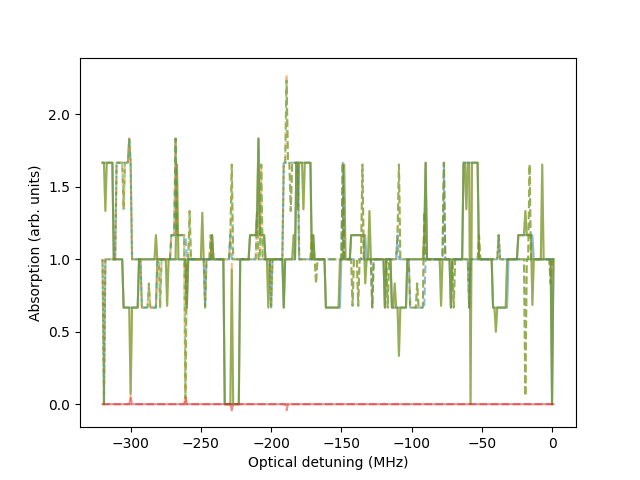

In [181]:
reset(pops)
offset = -195
freq_bb = excited["b"] - ground["b"] + offset
freq_ac = excited["c"] - ground["a"] + offset
freq_ab = excited["b"] - ground["a"] + offset
freq_ca = excited["a"] - ground["c"] + offset
freq_cb = excited["b"] - ground["c"] + offset

probe_scan = 8
probe_freqs = np.arange(-320, 2)
transitions = ["bb", "ac", "ca"]
#transitions = ["aa", "ab", "ba", "bc", "cb", "cc"]
#transitions = ["bb"]

chasm_width = 5

for ll in range(100):
    #optical_pump(pops, (freq_ac - chasm_width, freq_ac + chasm_width))
    #optical_pump(pops, (-(freq_ac - chasm_width), -(freq_ac + chasm_width)))
    #optical_pump(pops, (freq_ca - chasm_width, freq_ca + chasm_width))
    optical_pump(pops, (freq_bb - chasm_width, freq_bb + chasm_width))
    optical_pump(pops, (-(freq_bb - chasm_width), -(freq_bb + chasm_width)))
    optical_pump(pops, 0)
    rf_flop(pops, "a", "b")
    rf_flop(pops, "abar", "bbar")
chasm = absorption(pops, probe_freqs, transitions)
chasm_negative = absorption(pops, -probe_freqs, transitions)
for ll in range(100):
    rf_flop(pops, "abar", "bbar")
    rf_flop(pops, "a", "b", 0.05)
    optical_pump(pops, freq_ac)
    optical_pump(pops, -freq_ac)
    optical_pump(pops, 0)
    optical_pump(pops, freq_ca)
    optical_pump(pops, -freq_ca)
    optical_pump(pops, 0)
antihole = absorption(pops, probe_freqs, transitions)
antihole_negative = absorption(pops, -probe_freqs, transitions)
rf_flop(pops, "a", "b", 0.05)
rf = absorption(pops, probe_freqs, transitions)
rf_negative = absorption(pops, -probe_freqs, transitions)

# fig, ax = plt.subplots()
# ax.plot(freqs, [pops["a"][kk] for kk in freqs], linewidth=3, alpha=0.5, label="a")
# ax.plot(freqs, [pops["b"][kk] for kk in freqs], linewidth=3, alpha=0.5, label="b")
# ax.plot(freqs, [pops["c"][kk] for kk in freqs], linewidth=3, alpha=0.5, label="c")
# ax.plot(freqs, [pops["abar"][kk] for kk in freqs], linewidth=3, alpha=0.5, label="$\\bar{a}$", ls="--")
# ax.plot(freqs, [pops["bbar"][kk] for kk in freqs], linewidth=3, alpha=0.5, label="$\\bar{b}$", ls="--")
# ax.plot(freqs, [pops["cbar"][kk] for kk in freqs], linewidth=3, alpha=0.5, label="$\\bar{c}$", ls="--")
# ax.set_ylabel("Population")
# ax.set_xlabel("Spectroscopic class optical offset frequency (MHz)")
# ax.set_xlim(-20, 20)
# ax.legend()
# plt.show()

fig, ax = plt.subplots()
ax.plot(probe_freqs, chasm, alpha=0.5, color="C0")
ax.plot(probe_freqs, antihole, alpha=0.5, color="C1")
ax.plot(probe_freqs, rf, alpha=0.5, color="C2")
ax.plot(probe_freqs, rf - antihole, alpha=0.5, color="C3")
ax.plot(np.flip(probe_freqs), chasm_negative, alpha=0.5, color="C0", ls="--")
ax.plot(np.flip(probe_freqs), antihole_negative, alpha=0.5, color="C1", ls="--")
ax.plot(np.flip(probe_freqs), rf_negative, alpha=0.5, color="C2", ls="--")
ax.plot(np.flip(probe_freqs), rf_negative - antihole_negative, alpha=0.5, color="C3", ls="--")
ax.set_ylabel("Absorption (arb. units)")
ax.set_xlabel("Optical detuning (MHz)")
plt.show()

In [129]:
freq_ca

-58

In [128]:
freq_bb

-228

In [127]:
freq_ac

-300